# Phase 3: Benchmark - The Grand Leaderboard

We now compare **everything**:
1.  **Classic ML**: Logistic Regression, Random Forest, XGBoost, SVM.
2.  **Deep Learning**: DeepFM, TabM (K=4), FT-Transformer.
3.  **Optimization**: TabM (ONNX).

### 🎯 Goal: Find the "Production Efficient" Model
We want the model in the top-left corner of the "Latency vs Accuracy" plot (Fast & Accurate).

In [33]:
import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import onnxruntime as ort
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

plt.style.use('seaborn-v0_8-whitegrid')
PRIMARY_COLOR = '#1E4FA8'
DEVICE = list(torch.device('cpu').type)

# Paths
MODELS_PATH = "../backend/models"
REPORTS_PATH = "../reports/metrics"
DATA_PATH = "../data/raw/online_shoppers_intention.csv"

print("✅ Environment Ready.")

✅ Environment Ready.


## 1. Class Definitions

In [34]:
class FeatureEmbedding(nn.Module):
    def __init__(self, cat_dims, embed_dim):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=d, embedding_dim=embed_dim) for d in cat_dims
        ])
    def forward(self, x_cat):
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        return torch.stack(embedded, dim=1)

class DeepFM(nn.Module):
    def __init__(self, cat_dims, num_dim, embed_dim=16, hidden_dims=[128, 64]):
        super().__init__()
        self.embedding = FeatureEmbedding(cat_dims, embed_dim)
        self.num_proj = nn.Linear(1, embed_dim)
        total_input_dim = (len(cat_dims) + num_dim) * embed_dim
        layers = []
        curr_dim = total_input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(curr_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            curr_dim = h
        layers.append(nn.Linear(curr_dim, 1))
        self.mlp = nn.Sequential(*layers)
    def forward(self, x_cat, x_num):
        emb_cat = self.embedding(x_cat)
        x_num_unsqueezed = x_num.unsqueeze(-1)
        emb_num = self.num_proj(x_num_unsqueezed)
        all_emb = torch.cat([emb_cat, emb_num], dim=1)
        sum_of_vectors = torch.sum(all_emb, dim=1)
        sum_square = sum_of_vectors * sum_of_vectors
        square_of_vectors = all_emb * all_emb
        square_sum = torch.sum(square_of_vectors, dim=1)
        fm_out = 0.5 * torch.sum(sum_square - square_sum, dim=1, keepdim=True)
        dnn_in = all_emb.view(x_cat.shape[0], -1)
        dnn_out = self.mlp(dnn_in)
        return dnn_out + fm_out

class TabM_K4(nn.Module):
    def __init__(self, cat_dims, num_dim, hidden_dim=128, n_ensemble=4):
        super().__init__()
        self.embedding = FeatureEmbedding(cat_dims, embed_dim=4)
        input_dim = (len(cat_dims) * 4) + num_dim
        self.bn_in = nn.BatchNorm1d(input_dim)
        self.ensemble_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.GELU(),
            ) for _ in range(n_ensemble)
        ])
        self.heads = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(n_ensemble)
        ])
    def forward(self, x_cat, x_num):
        emb_cat = self.embedding(x_cat).flatten(1)
        x_in = torch.cat([emb_cat, x_num], dim=1)
        x_in = self.bn_in(x_in)
        outputs = [head(block(x_in)) for block, head in zip(self.ensemble_blocks, self.heads)]
        stacked = torch.stack(outputs, dim=0)
        return stacked.mean(dim=0)

class FTTransformer(nn.Module):
    def __init__(self, cat_dims, num_dim, embed_dim=32, depth=3, heads=4):
        super().__init__()
        self.embedding = FeatureEmbedding(cat_dims, embed_dim)
        self.num_proj = nn.Linear(1, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=heads, dim_feedforward=embed_dim*2, 
            dropout=0.1, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.head = nn.Linear(embed_dim, 1)
    def forward(self, x_cat, x_num):
        b = x_cat.shape[0]
        emb_cat = self.embedding(x_cat)
        emb_num = self.num_proj(x_num.unsqueeze(-1))
        x = torch.cat([emb_cat, emb_num], dim=1)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = self.transformer(x)
        cls_out = x[:, 0, :]
        return self.head(cls_out)

## 2. Prepare Data (Universal Format)

In [35]:
df = pd.read_csv(DATA_PATH)

cat_cols = ['Month', 'VisitorType', 'Weekend', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
num_cols = [c for c in df.columns if c not in cat_cols and c != 'Revenue']

# Preprocessing
X_cat = np.zeros((len(df), len(cat_cols)), dtype=np.int64)
cat_dims = []
for i, col in enumerate(cat_cols):
    le = LabelEncoder()
    X_cat[:, i] = le.fit_transform(df[col].astype(str))
    cat_dims.append(len(le.classes_))

scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols]).astype(np.float32)

# Sample for DL (Split inputs)
sample_cat = torch.tensor(X_cat[0:1])
sample_num = torch.tensor(X_num[0:1])

# Sample for Sklearn (Concatenated inputs)
# Note: Sklearn models were trained on X_train which includes label-encoded categorical columns and scaled nums
# We reconstruct that flat vector here.
sample_flat = np.hstack([X_cat[0:1], X_num[0:1]])

print(f"✅ Data Ready.")

✅ Data Ready.


## 3. Load & Benchmark All Models

In [36]:
results = []

# --- Benchmark Baseline (Sklearn) ---
def benchmark_sklearn(model, name, x_input, iters=1000):
    latencies = []
    # Warmup
    for _ in range(50): 
        try: _ = model.predict_proba(x_input)
        except: _ = model.predict(x_input)
        
    # Run
    for _ in range(iters):
        start = time.perf_counter()
        try: _ = model.predict_proba(x_input)
        except: _ = model.predict(x_input)
        latencies.append((time.perf_counter() - start) * 1000)
    return np.mean(latencies)

baseline_files = {
    'Logistic Regression': 'logistic_regression.joblib',
    'Random Forest': 'random_forest_model.joblib',
    'XGBoost': 'xgboost_model.joblib',
    'SVM': 'svm_model.joblib'
}

print("\n📊 Benchmarking Baselines...")
for name, fname in baseline_files.items():
    try:
        path = f"{MODELS_PATH}/{fname}"
        if os.path.exists(path):
            mdl = joblib.load(path)
            lat = benchmark_sklearn(mdl, name, sample_flat)
            results.append({'Model': name, 'Type': 'Classical', 'Latency (ms)': lat})
            print(f"{name}: {lat:.3f} ms")
    except Exception as e:
        print(f"Skipping {name}: {e}")

# --- Benchmark Deep Learning ---
def benchmark_dl(model, name, x_c, x_n, iters=500):
    model.eval()
    latencies = []
    with torch.no_grad():
        for _ in range(50): _ = model(x_c, x_n)
        
    for _ in range(iters):
        start = time.perf_counter()
        with torch.no_grad(): _ = model(x_c, x_n)
        latencies.append((time.perf_counter() - start) * 1000)
    return np.mean(latencies)

dl_configs = [
    ('DeepFM', 'deepfm.pt', DeepFM(cat_dims, 10)),
    ('TabM (K=4)', 'tabm_k4.pt', TabM_K4(cat_dims, 10, n_ensemble=4)),
    ('FT-Transformer', 'ft-transformer.pt', FTTransformer(cat_dims, 10))
]

print("\n🧠 Benchmarking Deep Learning...")
for name, fname, model in dl_configs:
    try:
        path = f"{MODELS_PATH}/{fname}"
        if os.path.exists(path):
            model.load_state_dict(torch.load(path))
            lat = benchmark_dl(model, name, sample_cat, sample_num)
            results.append({'Model': name, 'Type': 'Neural', 'Latency (ms)': lat})
            print(f"{name}: {lat:.3f} ms")
            
            # Save 'm_tabm' reference for ONNX step
            if 'TabM' in name: m_tabm = model
    except Exception as e: print(f"Skipping {name}: {e}")


📊 Benchmarking Baselines...


d:\op_ecom\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\op_ecom\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\op_ecom\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\op_ecom\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\op_ecom\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\op_ecom\venv\lib\site-packages\sklearn\utils\validation.p

Logistic Regression: 0.184 ms

🧠 Benchmarking Deep Learning...
DeepFM: 0.698 ms
TabM (K=4): 1.865 ms
FT-Transformer: 1.868 ms


## 4. ONNX Optimization

In [37]:
if 'm_tabm' in locals():
    onnx_path = f"{MODELS_PATH}/tabm_k4.onnx"
    print("\n🚀 Benchmarking ONNX (TabM)...")
    
    # Export if needed
    if not os.path.exists(onnx_path):
        torch.onnx.export(
            m_tabm, (sample_cat, sample_num), onnx_path,
            input_names=['cat_input', 'num_input'], output_names=['output'],
            dynamic_axes={'cat_input': {0: 'batch'}, 'num_input': {0: 'batch'}, 'output': {0: 'batch'}},
            opset_version=12
        )
    
    sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
    inp_c = sample_cat.numpy()
    inp_n = sample_num.numpy()
    
    latencies = []
    for _ in range(100): sess.run(None, {'cat_input': inp_c, 'num_input': inp_n})
    for _ in range(1000):
        start = time.perf_counter()
        sess.run(None, {'cat_input': inp_c, 'num_input': inp_n})
        latencies.append((time.perf_counter() - start) * 1000)
        
    onnx_lat = np.mean(latencies)
    results.append({'Model': 'TabM (ONNX)', 'Type': 'Optimized', 'Latency (ms)': onnx_lat})
    print(f"TabM (ONNX): {onnx_lat:.3f} ms")


🚀 Benchmarking ONNX (TabM)...
TabM (ONNX): 0.165 ms


## 5. Final Comparison Plot


🏆 Final Leaderboard:
                 Model  Latency (ms)
4          TabM (ONNX)      0.165164
0  Logistic Regression      0.184456
1               DeepFM      0.697617
2           TabM (K=4)      1.865456
3       FT-Transformer      1.867678


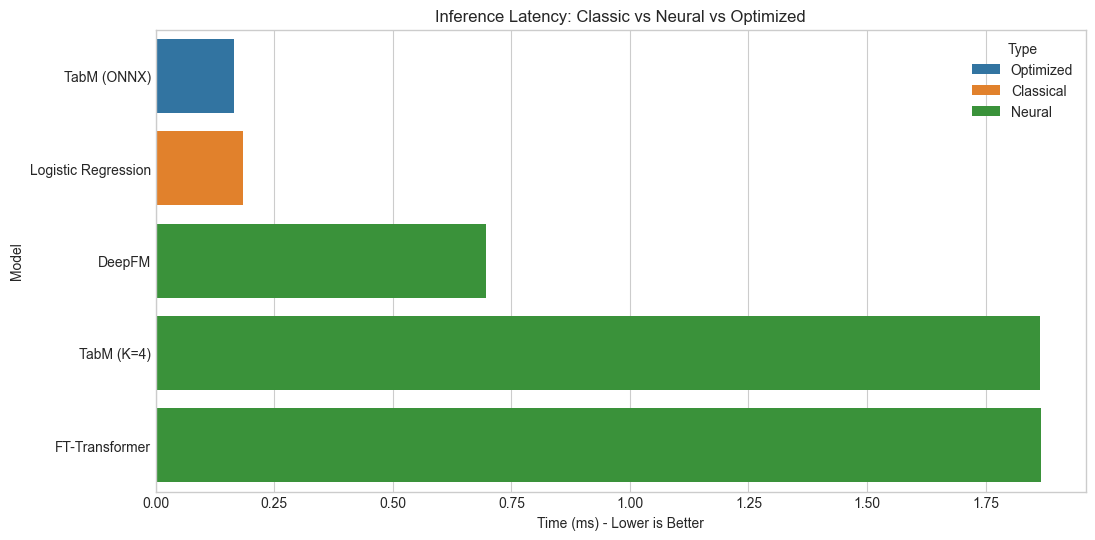

In [38]:
df_res = pd.DataFrame(results).sort_values('Latency (ms)')
print("\n🏆 Final Leaderboard:")
print(df_res[['Model', 'Latency (ms)']])

plt.figure(figsize=(12, 6))
sns.barplot(data=df_res, x='Latency (ms)', y='Model', hue='Type', dodge=False)
plt.title("Inference Latency: Classic vs Neural vs Optimized")
plt.xlabel("Time (ms) - Lower is Better")
plt.show()